# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))
train_classes = set([item.replace("dogImages/train/", "") for item in np.array(glob("dogImages/train/*"))])
valid_classes = set([item.replace("dogImages/valid/", "") for item in np.array(glob("dogImages/valid/*"))])
test_classes = set([item.replace("dogImages/test/", "") for item in np.array(glob("dogImages/test/*"))])
# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))
print(f"Classes are all same? {set(train_classes) == set(valid_classes) == set(test_classes)}")


There are 13233 total human images.
There are 8351 total dog images.
Classes are all same? True


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


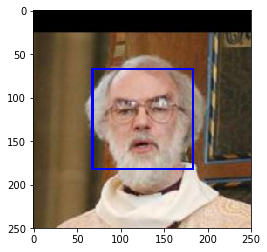

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [62]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def count_pics_with_face(files):    
    totalThatHaveAFace = 0

    for i in range(len(files)):
        if face_detector(files[i]):
            totalThatHaveAFace += 1
    return totalThatHaveAFace / len(files)

print(f"Human pictures : {count_pics_with_face(human_files_short)}%")
print(f"Dog puctures   : {count_pics_with_face(dog_files_short)}%")

Human pictures : 0.98%
Dog puctures   : 0.17%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [5]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)
DENSENET161 = models.densenet161(pretrained=True)
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    DENSENET161 = DENSENET161.cuda()
    print("going to use CUDA! :D")
else:
    print("Not using CUDA D:")
    
    

going to use CUDA! :D


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from matplotlib.image import imread

# transforms
pilResizedToTensor = transforms.Compose([
    transforms.transforms.Resize((224, 224)), 
    transforms.ToTensor()])

tensorToPil = transforms.Compose([
    transforms.ToPILImage()])



In [8]:

def img_path_2_RGB_tensor(img_path):
    pil_img = Image.open(img_path).convert('RGB')
    tensor_img = pilResizedToTensor(pil_img)
    if True:
        tensor_img = tensor_img.cuda()
    return tensor_img[:3,:,:].unsqueeze(0)


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''

    VGG16.eval()
    output = VGG16(img_path_2_RGB_tensor(img_path))
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return preds.item() # predicted class index

def DENSENET161_predict(img_path):
    DENSENET161.eval()
    output = DENSENET161(img_path_2_RGB_tensor(img_path))
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return preds.item() # predicted class index
    
print(VGG16_predict('dogImages/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00691.jpg'))
print(DENSENET161_predict('dogImages/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00691.jpg'))

222
235


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    classIndex = VGG16_predict(img_path)
    
    return classIndex >= 151 and classIndex <= 268 # true/false

def dog_detectorDENSENET161(img_path):
    ## TODO: Complete the function.
    
    classIndex = DENSENET161_predict(img_path)
    # indexes: https://www.deepdetect.com/models/densenet/densenet_161_48/corresp.txt
    return classIndex >= 151 and classIndex <= 268 # true/false


print(dog_detector('dogImages/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00691.jpg'))
print(dog_detector('dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00752.jpg'))
print(dog_detector('dogImages/train/098.Leonberger/Leonberger_06592.jpg'))

print(dog_detectorDENSENET161('dogImages/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00691.jpg'))
print(dog_detectorDENSENET161('dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00752.jpg'))
print(dog_detectorDENSENET161('dogImages/train/098.Leonberger/Leonberger_06592.jpg'))

True
True
True
True
True
True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

Using a sample of 100 human pictures and 100 dogs:
- 0.0% of human pics have a dog
- 0.96% of dogs pics have a dog


In [63]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def assess_dog_detector(use_dense_net=False):
    sampleSize = 100

    human_files_short = human_files[:sampleSize]
    dog_files_short = dog_files[:sampleSize]

    human_pics_with_dogs=0
    dog_pics_with_dogs=0

    for i in range(len(human_files_short)):
        if dog_detectorDENSENET161(human_files_short[i]) if use_dense_net else dog_detector(human_files_short[i]):
            human_pics_with_dogs += 1
        if dog_detectorDENSENET161(dog_files_short[i]) if use_dense_net else dog_detector(dog_files_short[i]):
            dog_pics_with_dogs += 1
    print(f"With use_dense_net=={use_dense_net}")
    print(f"{human_pics_with_dogs / len(human_files_short)}% of human pics have a dog")        
    print(f"{dog_pics_with_dogs / len(human_files_short)}% of dogs pics have a dog")        



In [64]:
%%time
assess_dog_detector(use_dense_net=False)


With use_dense_net==False
0.0% of human pics have a dog
0.96% of dogs pics have a dog
CPU times: user 35.4 s, sys: 2.48 s, total: 37.9 s
Wall time: 9.49 s


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [65]:
%%time

### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

assess_dog_detector(use_dense_net=True)

With use_dense_net==True
0.0% of human pics have a dog
0.88% of dogs pics have a dog
CPU times: user 42.3 s, sys: 1.14 s, total: 43.5 s
Wall time: 10.9 s


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [13]:
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

dog_classes = np.array(glob("dogImages/train/*"))

dog_classes = list(map(lambda s: s.replace('dogImages/train/', ''), dog_classes))
dog_classes.sort()

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.  ' % len(dog_files))
print('There are %d total dog classes. ' % len(dog_classes))

print('dog classes: ', dog_classes)


# define training and test data directories
data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
valid_dir = os.path.join(data_dir, 'valid/')

# classes are folders in each directory with these names
classes = dog_classes

# load and transform data using ImageFolder

# RESNET Takes 224x224 images as input, so we resize all of them
training_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                     transforms.RandomAffine(8), 
                                     transforms.RandomHorizontalFlip(), 
                                     transforms.RandomRotation(8), 
                                      transforms.ToTensor()])

normal_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                      transforms.ToTensor()])


train_data = datasets.ImageFolder(train_dir, transform=training_transform)
test_data = datasets.ImageFolder(test_dir, transform=normal_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=normal_transform)

# print out some data stats
print('Num training images  : ', len(train_data))
print('Num test images      : ', len(test_data))
print('Num validation images: ', len(valid_data))

# define dataloader parameters
batch_size = 5
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

There are 13233 total human images.
There are 8351 total dog images.  
There are 133 total dog classes. 
dog classes:  ['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_te

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: 
- Some labels don't have a lot of samples, but we can use a RandomAffine to stretch the image, RandomHorizontalFlip to flip the left-to-right and vice versa. Input size is 224x224 since we're using VGG16, the first Conv2D layer takes these dimension as an input.
- Yes, I decided to augment the dataset, because some classes have far fewer examples in the training set.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1, stride=2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1, stride=2)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (256, 3, 3 (2304) -> 1200)
        self.fc1 = nn.Linear(256*3*3, 1200)
        # linear layer (1000 -> 133)
        self.fc2 = nn.Linear(1200, 600)
        # linear layer (1000 -> 133)
        self.fc3 = nn.Linear(600, len(dog_classes))
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        #print("->", x.shape)
        # flatten image input
        x = x.view(-1, 256*3*3)
        #print(x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        #print(x.shape)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [125]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
- I started with the cifar exercise Net, which has:
 - 3 Conv2d layers
 - 2 fully connected layers
- The cifar exercise net was designed for small images and it only had a stride of 1
- Since our dataset has much larger images we can:
 - take a double stride to make the next Cond2D layer see an image that is 1/4 the size
 - double the number of kernel layers. 
- funneled the fully connected layers down to so:
 - 2304
 - 1200
 - 133 (the number of dog classes).
- Used Dropout with 25% change of a node's output be randomly set to 0

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [55]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)



### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [132]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
import datetime
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        epoch_start_time = datetime.datetime.now()
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()
            
            if batch_idx % batch_size == (batch_size - 1):    # print training loss every specified number of mini-batches
                print(f"Epoch {epoch}, Batch {batch_idx + 1} loss: {train_loss / batch_size}")
                train_loss = 0.0

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        print(f"{(datetime.datetime.now() - epoch_start_time).total_seconds()} seconds/epoch.")

    return model


# train the model
model_scratch = train(200, train_loader, valid_loader, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch 1, Batch 20 loss: 4.0750694394111635
Epoch 1, Batch 40 loss: 4.03433266878128
Epoch 1, Batch 60 loss: 3.881481611728668
Epoch 1, Batch 80 loss: 3.925376260280609
Epoch 1, Batch 100 loss: 4.066278982162475
Epoch 1, Batch 120 loss: 3.987042319774628
Epoch 1, Batch 140 loss: 4.070370614528656
Epoch 1, Batch 160 loss: 4.023146295547486
Epoch 1, Batch 180 loss: 3.922244119644165
Epoch 1, Batch 200 loss: 3.98308470249176
Epoch 1, Batch 220 loss: 3.9786120772361757
Epoch 1, Batch 240 loss: 4.05682772397995
Epoch 1, Batch 260 loss: 4.071619296073914
Epoch 1, Batch 280 loss: 3.9689613580703735
Epoch 1, Batch 300 loss: 3.9836631417274475
Epoch 1, Batch 320 loss: 4.004702520370484
Epoch: 1 	Training Loss: 0.008497 	Validation Loss: 3.972221
Validation loss decreased (inf --> 3.972221).  Saving model ...
84.720714 seconds/epoch.
Epoch 2, Batch 20 loss: 3.8950504660606384
Epoch 2, Batch 40 loss: 3.8997594118118286
Epoch 2, Batch 60 loss: 4.0202171325683596
Epoch 2, Batch 80 loss: 4.0038030385

KeyboardInterrupt: 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [52]:

model_scratch.load_state_dict(torch.load('model_scratch.pt'))

In [53]:
def test(loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [56]:

# call test function    
test(test_loader, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.579188


Test Accuracy: 17% (148/836)


In [57]:
def display_sample_predictions(model, loader):
    torch.cuda.empty_cache()
    model.eval()
    # obtain one batch of test images
    dataiter = iter(loader)
    images, labels = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    if use_cuda:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(40, 40))
    
    num_correct = 0
    for idx in np.arange(batch_size):
        correct = preds[idx]==labels[idx].item()
        if correct:
            num_correct += 1
        ax = fig.add_subplot(5, batch_size/5, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
        ax.set_title("{} ({})".format(classes[preds[idx]][4:], classes[labels[idx]][4:]),
                     color=("green" if correct else "red"))

    return num_correct / batch_size
                

0.2

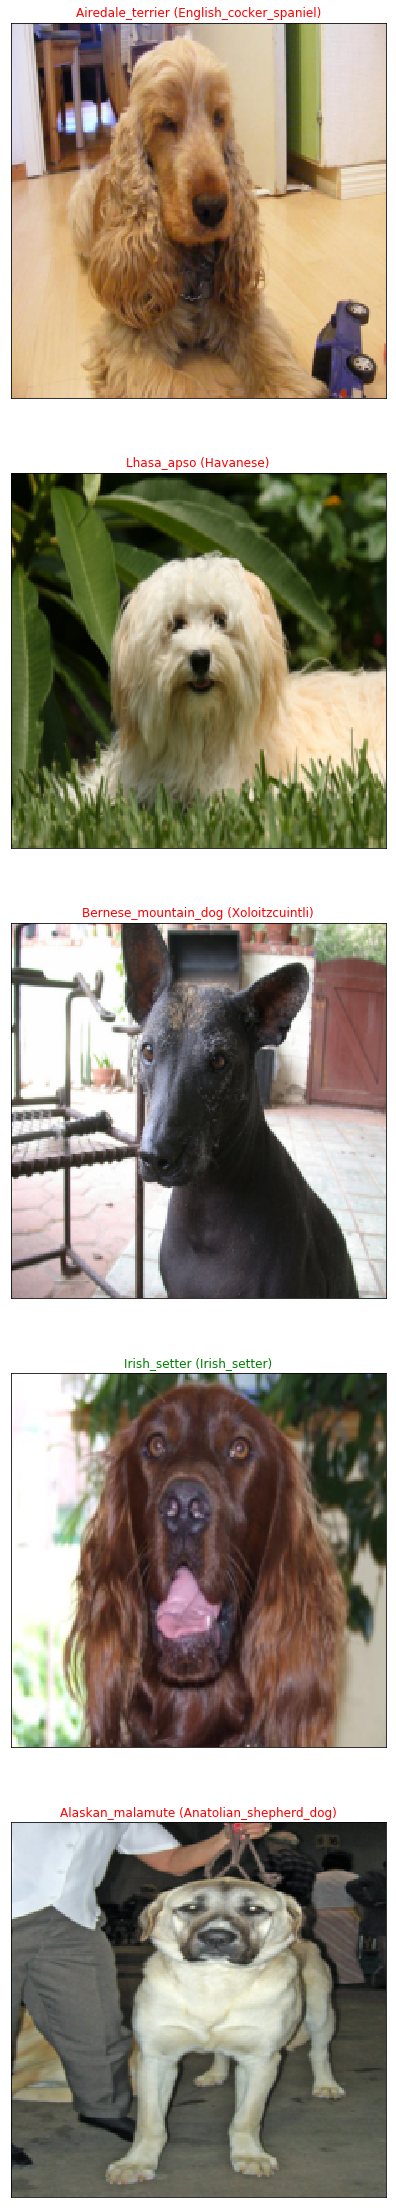

In [60]:
display_sample_predictions(model=model_scratch, loader=test_loader)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [16]:
## TODO: Specify data loaders
# just going to use the same loaders from the hand rolled CNN

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
import torchvision.models as models
import torch.nn as nn

# going to try RESNET101
model_transfer = models.resnet101(pretrained=True)

# modifiy last fully connected later to have (n_inputs -> 133 dog classes)
model_transfer.fc = nn.Linear(model_transfer.fc.in_features, len(classes))

if use_cuda:
    model_transfer = model_transfer.cuda()

def freeze_base_params():
    # see this for how to freeze base params: https://discuss.pytorch.org/t/how-to-perform-finetuning-in-pytorch/419/8
    ignored_params = list(map(id, model_transfer.fc.parameters()))
    base_params = filter(lambda p: id(p) not in ignored_params,
                         model_transfer.parameters())
    for param in base_params:
        param.requires_grad = False
        
freeze_base_params()

print(model_transfer)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
- Start with ResNet101 with pretrained weights.
 - Since the pretrained weights for ResNet101 can classify dogs, they likely have the same textures and needed for this task.
 - ResNet101 has a higher accuracy than VGG16.
- Replace the last Fully Connected Linear Layer to have 133 outputs, one per dog breed.
- Freeze every layer EXCEPT the last Fully Connected Linear Layer, we want to use the pretrained weights.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [18]:
## TODO: Specify data loaders

import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion_transfer = nn.CrossEntropyLoss()

# we want to minimize loss of model.fc.parameters
# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001, momentum=0.9)


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [28]:
# train the model
#model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


### TRAINING
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

save_model_name = 'model_transfer.pt'
exists = False #os.path.isfile(save_model_name)
if exists:
    model_transfer.load_state_dict(torch.load(save_model_name))
    valid_loss_min = 1 # track change in validation loss
    print(f"Loaded model from file: {save_model_name}")
else: 
    valid_loss_min = np.Inf # track change in validation loss

#assert use_cuda, "You really should run this with CUDA, disable this assert if you want to run on cpu."
    
# number of epochs to train the model
n_epochs = 50

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0    
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    model_transfer.train()
    # Freeze training for all "features" layers
    freeze_base_params()
    
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_transfer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_transfer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % batch_size == 0:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / batch_size)) # average loss / batch
            train_loss = 0.0
            
    ######################    
    # validate the model #
    ######################
    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model_transfer.state_dict(), 'model_transfer.pt')
        valid_loss_min = valid_loss            


# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 1, Batch 1 loss: 0.2517694711685181
Epoch 1, Batch 21 loss: 4.9340505838394169
Epoch 1, Batch 41 loss: 4.8704339027404782
Epoch 1, Batch 61 loss: 4.7524935007095337
Epoch 1, Batch 81 loss: 4.6084273099899296
Epoch 1, Batch 101 loss: 4.5136227130889894
Epoch 1, Batch 121 loss: 4.3668478488922116
Epoch 1, Batch 141 loss: 4.3723705768585202
Epoch 1, Batch 161 loss: 4.2032070040702818
Epoch 1, Batch 181 loss: 4.0876781702041622
Epoch 1, Batch 201 loss: 4.0222810983657835
Epoch 1, Batch 221 loss: 3.9153454303741455
Epoch 1, Batch 241 loss: 3.7836324810981750
Epoch 1, Batch 261 loss: 3.6932461857795715
Epoch 1, Batch 281 loss: 3.6775966644287110
Epoch 1, Batch 301 loss: 3.5906024932861329
Epoch 1, Batch 321 loss: 3.4915507316589354
Epoch: 1 	Training Loss: 0.006711 	Validation Loss: 3.085465
Validation loss decreased (inf --> 3.085465).  Saving model ...
Epoch 2, Batch 1 loss: 0.1732672095298767
Epoch 2, Batch 21 loss: 3.3330512404441834
Epoch 2, Batch 41 loss: 3.2428392052650450
Epoch

KeyboardInterrupt: 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [19]:
# going to try RESNET101
model_transfer = models.resnet101(pretrained=True)
# modifiy last fully connected later to have (n_inputs -> 133 dog classes)
model_transfer.fc = nn.Linear(model_transfer.fc.in_features, len(classes))
model_transfer.load_state_dict(torch.load('model_transfer_resnet101_4_16.pt'))
model_transfer.eval()

if use_cuda:
    model_transfer = model_transfer.cuda()



Display a few batches of images with the Expected vs Actual results from the test_loader

0.8

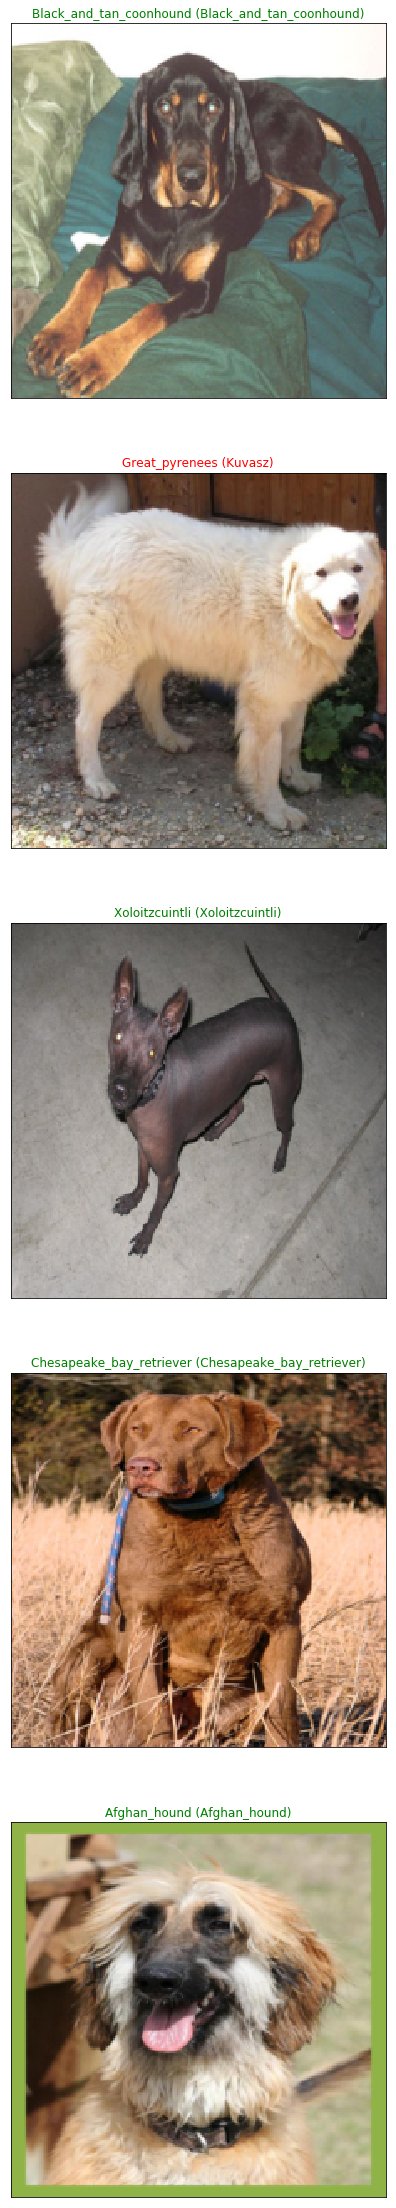

In [61]:
display_sample_predictions(model_transfer, test_loader)

In [27]:
test(test_loader, model_transfer, criterion_transfer, True)

Test Loss: 0.566144


Test Accuracy: 83% (696/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [46]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.


def predict_breed_transfer(img_path):
    ## TODO: Complete the function.
    pil_img = Image.open(img_path).convert('RGB')
    tensor_img = pilResizedToTensor(pil_img)
    if use_cuda:
        tensor_img = tensor_img.cuda()

    model_transfer.eval()
    output = model_transfer(tensor_img[:3,:,:].unsqueeze(0))
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    class_index = preds.item() # predicted class index
    
    
    return classes[class_index][4:].replace("_", " ")


print(predict_breed_transfer('dogImages/test/098.Leonberger/Leonberger_06617.jpg'))
print(predict_breed_transfer('dogImages/test/095.Kuvasz/Kuvasz_06409.jpg'))
print(predict_breed_transfer('dogImages/test/064.English_toy_spaniel/English_toy_spaniel_04513.jpg'))
print(predict_breed_transfer('dogImages/test/041.Bullmastiff/Bullmastiff_02921.jpg'))
print(predict_breed_transfer('dogImages/test/032.Boston_terrier/Boston_terrier_02291.jpg'))
print(predict_breed_transfer('dogImages/test/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01801.jpg'))


Leonberger
Great pyrenees
Cavalier king charles spaniel
Bullmastiff
Boston terrier
Black and tan coonhound


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [47]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def display_img_from_file(img_path):
    pil_img = Image.open(img_path).convert('RGB')
    plt.figure()
    plt.imshow(pil_img)
    plt.show()

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path) == True:
        print("Woof Woof!")
        display_img_from_file(img_path)
        print(f"This dog looks like a {predict_breed_transfer(img_path)}!")
    elif face_detector(img_path) == True:
        print("Howdy human!")
        display_img_from_file(img_path)
        print(f"You look like a {predict_breed_transfer(img_path)}?!?")

    else:
        print("No dog, nor human detected D:")
        
    print("\n\n")
        
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__
- I'm pretty shocked at how well this works. Particularly since I only trained the transfer model for ~2 hours! I can't tell the difference between these dog breeds, so I obviously outperforms me. I'd bet it would outperform the majority of people as well.

- Three ways to improve algorithm:
 - Detect multiple dogs in the image. What if we had a bunch of dogs in the image?
 - Increase accuracy by training for a longer time, I just traind for about 2 hours on the Udacity GPU workspace.
 - Crop image to try to only see the dog part. This would minimize error from detecting texture from furnature or carpet.

Howdy human!


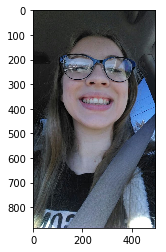

You look like a Silky terrier?!?



Howdy human!


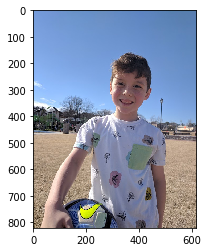

You look like a Bull terrier?!?



Howdy human!


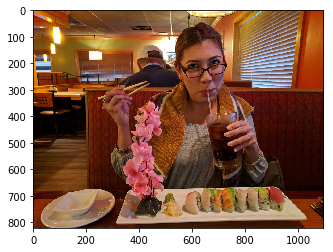

You look like a Chinese crested?!?



Howdy human!


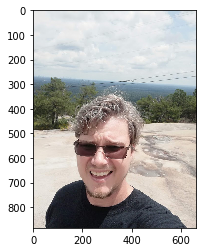

You look like a Cane corso?!?



Howdy human!


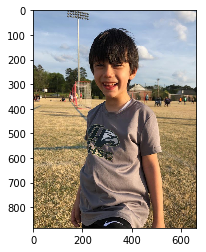

You look like a Bulldog?!?



Howdy human!


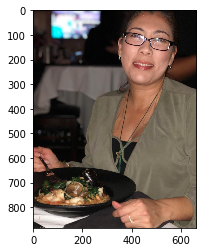

You look like a Cavalier king charles spaniel?!?



Howdy human!


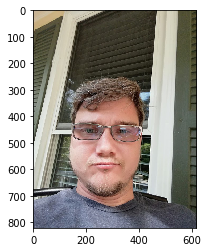

You look like a Chinese crested?!?



Howdy human!


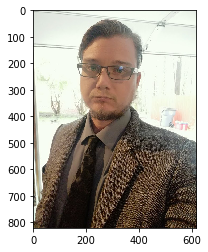

You look like a English toy spaniel?!?



Howdy human!


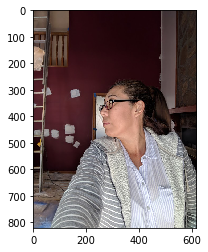

You look like a Poodle?!?



No dog, nor human detected D:





In [51]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
myImages = np.array(glob("myImages/*"))

## suggested code, below
for file in np.hstack(myImages):
    run_app(file)